This is a preprocessing workflow including :  
1. Motion-correction  
2. Artifact Detection  
3. Coregistration from functional to anatomical pictures in two steps  
4. Smoothing  
5. Grey-matter masking  
6. and Detrending  

First, we import all the necessary modules:

In [2]:
from nipype import Node, MapNode, Workflow, SelectFiles, Function
from nipype.interfaces.fsl import MCFLIRT, Smooth, FLIRT, ApplyMask, ConvertXFM, ImageMaths
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.algorithms.confounds import TSNR
from bids import BIDSLayout
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
from nilearn import image as nli

This is just to get an idea of the data structure, while setting up the workflow (look up how files are named in BIDS)

In [5]:
layout = BIDSLayout('fps_bids/')
layout

BIDS Layout: .../home/neuro/fps/fps_bids | Subjects: 2 | Sessions: 0 | Runs: 0

In [6]:
layout.get(suffix = 'bold')

[<BIDSFile filename='sub-01/func/sub-01_task-fps_acq-mb_bold.json'>,
 <BIDSFile filename='sub-01/func/sub-01_task-fps_acq-mb_bold.nii.gz'>,
 <BIDSFile filename='sub-01/func/sub-01_task-fps_acq-wh_bold.json'>,
 <BIDSFile filename='sub-01/func/sub-01_task-fps_acq-wh_bold.nii.gz'>,
 <BIDSFile filename='sub-01/func/sub-01_task-fps_bold.json'>,
 <BIDSFile filename='sub-01/func/sub-01_task-fps_bold.nii.gz'>,
 <BIDSFile filename='sub-02/func/sub-02_task-fps_acq-mb_bold.json'>,
 <BIDSFile filename='sub-02/func/sub-02_task-fps_acq-mb_bold.nii.gz'>,
 <BIDSFile filename='sub-02/func/sub-02_task-fps_acq-wh_bold.json'>,
 <BIDSFile filename='sub-02/func/sub-02_task-fps_acq-wh_bold.nii.gz'>,
 <BIDSFile filename='sub-02/func/sub-02_task-fps_bold.json'>,
 <BIDSFile filename='sub-02/func/sub-02_task-fps_bold.nii.gz'>,
 <BIDSFile filename='task-fps_acq-mb_bold.json'>,
 <BIDSFile filename='task-fps_acq-wh_bold.json'>,
 <BIDSFile filename='task-fps_bold.json'>]

Below we create and define our preprocessing workflow step by step(i.e. the connections between the individual nodes).

In [7]:
func = layout.get(task='fps', extensions='.nii.gz', return_type='file')[0]
resolution = np.array(nb.load(func).header.get_zooms()[:3])

This creates the workflow :

In [8]:
preprocessing = Workflow(name='work_preprocessing', base_dir='/home/neuro/fps/fps_bids/derivatives/')

We created a Node which can select files using dictionaries, where the key can later be used to select input for other Nodes e.g. the functional files for the motion correction, see the first connection of Nodes below:

In [9]:
# String template with {}-based strings
templates = {'anat': 'sub-{subject_id}/anat/'
                     'sub-{subject_id}_T1w.nii.gz',
             'func': 'sub-{subject_id}/func/'
                     'sub-{subject_id}_task-{task_id}_bold.nii.gz',
             'wh':   'sub-{subject_id}/func/'
                     'sub-{subject_id}_task-{task_id}_acq-wh_bold.nii.gz',
             'mb':   'sub-{subject_id}/func/'
                     'sub-{subject_id}_task-{task_id}_acq-mb_bold.nii.gz',
             'brain':'derivatives/mindboggle/freesurfer_subjects/'
                     'sub-{subject_id}/mri/brain.mgz',
             'ribbon_lh':'derivatives/mindboggle/freesurfer_subjects/'
                     'sub-{subject_id}/mri/lh.ribbon.mgz',
             'ribbon_rh':'derivatives/mindboggle/freesurfer_subjects/'
                     'sub-{subject_id}/mri/rh.ribbon.mgz',
            }

# Create SelectFiles node
sf = Node(SelectFiles(templates,
                      base_directory='/home/neuro/fps/fps_bids/',
                      sort_filelist=True),
          name='selectfiles')
sf.inputs.task_id='fps'

Here, we can specify which of the subjects we want to run through this preprocessing pipeline, iterating over the subject Id's in the subject_list.

In [10]:
subject_list = ['01','02']
sf.iterables = [('subject_id', subject_list)]

Now we are defining the Nodes. These Nodes represent the different steps of our preprocessing, respectively. Later our workflow will be a directed acyclic graph (DAG) consisting of the interconnected Nodes.

Node for motion correction. We  use the mcflirt function from the interface fsl. The outputs of the function are motion corrected time series, a mean volume(first parameter of the mcflirt function) and a list of motion parameters(second parameter of the mcflirt function)

In [11]:
mo_correct = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                         ),
               name="mo_correct")

This is a good example of how to use the select file Node: when connecting this Node to another you can specify(through the keys) the Input given into the other Node. In this example the motion correction Node gets input from the sf Node which is specified by the key 'func', meaning all the functional images of the respective subject.

In [12]:
preprocessing.connect([(sf, mo_correct,[('func', 'in_file')])])

In [13]:
#preprocessing.write_graph("workflow_graph.dot")
#from IPython.display import Image
#Image(filename="/derivatives/preprocessing/workflow_graph.png")

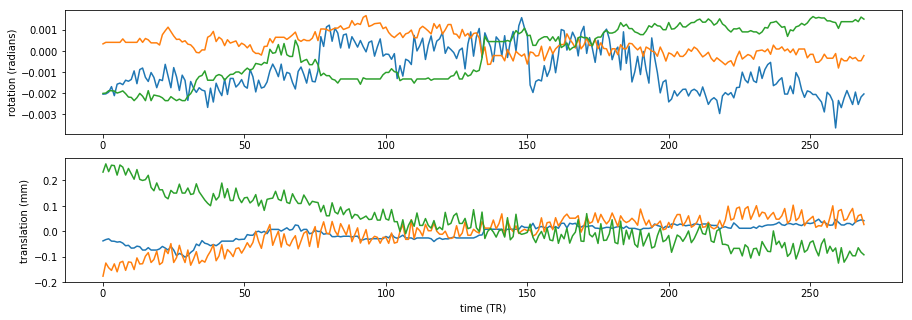

In [14]:
%matplotlib inline
# Plot the motion paramters
par = np.loadtxt('/home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_01/mo_correct/sub-01_task-fps_bold_mcf.nii.gz.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)');

The next step in our pipeline is the artifact correction, the respective Node is defined as follows:

In [15]:
arti_correct = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'), 
                    name="arti_correct")

For more information on the parameters of specific functions you can check like this: 

In [4]:
ArtifactDetect.help()

Help on class ArtifactDetect in module nipype.algorithms.rapidart:

class ArtifactDetect(nipype.interfaces.base.core.BaseInterface)
 |  Detects outliers in a functional imaging series
 |  
 |  Uses intensity and motion parameters to infer outliers. If `use_norm` is
 |  True, it computes the movement of the center of each face a cuboid centered
 |  around the head and returns the maximal movement across the centers. If you
 |  wish to use individual thresholds instead, import `Undefined` from
 |  `nipype.interfaces.base` and set `....inputs.use_norm = Undefined`
 |  
 |  
 |  Examples
 |  --------
 |  
 |  >>> ad = ArtifactDetect()
 |  >>> ad.inputs.realigned_files = 'functional.nii'
 |  >>> ad.inputs.realignment_parameters = 'functional.par'
 |  >>> ad.inputs.parameter_source = 'FSL'
 |  >>> ad.inputs.norm_threshold = 1
 |  >>> ad.inputs.use_differences = [True, False]
 |  >>> ad.inputs.zintensity_threshold = 3
 |  >>> ad.run()  # doctest: +SKIP
 |  
 |  Method resolution order:
 |    

As the function ArtifactDetect needs a list of realignment parameters and a 4D time series, we connect this Node to the mo_correction Node such that the output of the mo_correction Node flows into the arti_correct Node:

In [16]:
preprocessing.connect([(mo_correct, arti_correct, [('out_file', 'realigned_files'),
                                 ('par_file', 'realignment_parameters')])
                 ])

Now that we are done with the artifact correction we can do the coregistration. As the first step we will map our functional whole-head pictures to the anatomical, already skullstripped picture.


In order for this to happen, we first need to compute the mean of our functional whole-head pictures. The new function defined below does that for us. 

In [18]:
def compute_mean_image(image):

    from nilearn.image import mean_img
    from os.path import basename, abspath

    m_img = mean_img(image)
    mean_image_wh = abspath(basename(image).replace('.nii.gz', '_mean.nii'))
    m_img.to_filename(mean_image_wh)

    return mean_image_wh


Now we need to create a Node, that executes the previously defined function. If this function is not included in any packages and we had to write the function ourselves, we can do so by just setting Function as the first parameter of the Node and then specify which functions to use within the parameters of the Function argument:

In [19]:
compute_mean_wh = Node(Function(input_names=['image'],
                                output_names=['mean_image'],
                                function=compute_mean_image),
                      name='compute_mean_wh')

Additionally we need to define a function that converts the picture of the skullstripped brain (output of the mindboggle segmentation process) as we need 2 Nifti files to do the coregistration. The function we use to coregister is flirt from the fsl interface (see Nodes coreg_wh and coreg_slab below)

In [20]:
def convert_mgh(image):

    from nibabel import load, save, Nifti1Image
    from os.path import basename, abspath

    anat_img = load(image)
    anat_convert = Nifti1Image(anat_img.get_data(), affine=anat_img.get_affine())

    ant_image_nii = abspath(basename(image).replace('.mgz', '.nii'))

    save(anat_convert, ant_image_nii)
    
    return ant_image_nii

Again we need a Node to execute the function:

In [21]:
convert_mgh = Node(Function(input_names=['image'],
                                output_names=['ant_image_nii'],
                                function=convert_mgh),
                      name='convert_mgh')

The coregistration Nodes using the flirt function from the fsl interface, as mentioned above. coreg_wh coregisters the functional wholehead mean file onto the anatomical image and coreg_slab coregisters the mean functional picture of the fmri measures (which do not contain the whole head) to the wholehead functional image. Both Nodes will return a coregistration matrix.

In [17]:
coreg_wh = Node(FLIRT(dof=6,
                   output_type='NIFTI'),
             name="coreg_wh")

In [23]:
coreg_slab = Node(FLIRT(dof=6,
                   output_type='NIFTI'),
             name="coreg_slab")

In [22]:
preprocessing.connect([(sf, convert_mgh, [('brain', 'image')]),
                       (convert_mgh, coreg_wh, [('ant_image_nii', 'reference')]),
                       (sf, compute_mean_wh, [('wh', 'image')]),
                       (compute_mean_wh, coreg_wh, [('mean_image', 'in_file')])
                      ])

In [24]:
preprocessing.connect([(mo_correct, coreg_slab, [('mean_img', 'in_file')]),
                       (compute_mean_wh, coreg_slab, [('mean_image', 'reference')])
                      ])

Before being able to apply the coregistration to the whole time series, we need to connect the 2 computed coregistration matrices:

In [25]:
merge_trans = Node(ConvertXFM(concat_xfm=True), 
                  name='merge_trans')

In [26]:
preprocessing.connect([(coreg_wh, merge_trans, [('out_matrix_file', 'in_file2')]),
                       (coreg_slab, merge_trans, [('out_matrix_file', 'in_file')])
                      ])

Once the matrices are merged we use the applywarp Node to apply the coregistration warp functional images. This Node again takes the flirt function from the fsl interface with the coregistration matrix as an additional parameter. Check the help function again for more information on parameters!

In [ ]:
# Specify the isometric voxel resolution you want after coregistration
desired_voxel_iso = 3

applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=desired_voxel_iso,
                       output_type='NIFTI'),
                 name="applywarp")

In [ ]:
preprocessing.connect([(mo_correct,applywarp,[('out_file','in_file')]),
                       (merge_trans,applywarp,[('out_file','in_matrix_file')]),
                       (convert_mgh,applywarp, [('ant_image_nii', 'reference')])
                      ])

We are done with the coregistration and have mapped our time series into the anatomical space successfully, next to come is the smoothing. As recommended by our supervisor we will use the susan_smooth workflow as a subworkflow of ours to do the smoothing. This subworkflow allows for masking while smoothing and thereby only smoothing the important parts.

In [ ]:
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth

As done in the original paper, we will use a smoothing kernel with 3 mm full-width-half-maximum

In [ ]:
susan = create_susan_smooth(name='susan')
susan.inputs.inputnode.fwhm = 3

As mentioned above the susan_smoothing allows for masking throughout the process. The mindboggle segmentation already gives us grey matter masks, so we dont have to worry about creating a mask. What we need to do though is convert the mask and also concatenate right and left hemisphere, as we only get grey matter mask for each hemisphere respectively. To do so we need to set up a function again to convert mgz files to Nifti (we defined this function already for the coregistration remember? but we'll leave the code here for visualization). 

In [ ]:
def convert_ribbon(image):

    from nibabel import load, save, Nifti1Image
    from os.path import basename, abspath

    anat_img = load(image)
    anat_convert = Nifti1Image(anat_img.get_data(), affine=anat_img.get_affine())

    ant_image_nii = abspath(basename(image).replace('.mgz', '.nii'))

    save(anat_convert, ant_image_nii)
    
    return ant_image_nii

Now we create 2 Nodes (one for each hemisphere) and convert the masks into the Nifti format:

In [ ]:
convert_ribbon_lh = Node(Function(input_names=['image'],
                                output_names=['ribbon_lh'],
                                function=convert_ribbon),
                      name='convert_ribbon_lh')

In [ ]:
convert_ribbon_rh = Node(Function(input_names=['image'],
                                output_names=['ribbon_rh'],
                                function=convert_ribbon),
                      name='convert_ribbon_rh')

In [ ]:
preprocessing.connect([(sf, convert_ribbon_lh,[('ribbon_lh','image')]),
                       (sf, convert_ribbon_rh,[('ribbon_rh','image')]),
                      ])

After converting we concatenate the two hemispheres to get a mask for the whole brain:

In [ ]:
concat_ribbon = MapNode(ImageMaths(op_string='-add'), iterfield=['in_file'],
                       name='concat_ribbon')

In [ ]:
preprocessing.connect([(convert_ribbon_lh, concat_ribbon,[('ribbon_lh','in_file')]),
                       (convert_ribbon_rh, concat_ribbon,[('ribbon_rh','in_file2')]),
                      ])

As the grey matter mask does not have the same resolution as the functional pictures, we need to adjust this:

In [ ]:
resample = Node(FLIRT(apply_isoxfm=desired_voxel_iso), 
                name='resample')

In [ ]:
def get_file(files):
    
    return files[0]

In [ ]:
preprocessing.connect([(concat_ribbon, resample, [(('out_file', get_file), 'in_file')]),
                       (concat_ribbon, resample, [(('out_file', get_file), 'reference')]),
                      ])

Now everything is set and we can run the smoothing on the coregistered files with the converted, concatenated and resolution fitted grey matter mask:

In [ ]:
preprocessing.connect([(applywarp,susan, [('out_file','inputnode.in_files')]),
                       (resample, susan, [('out_file', 'inputnode.mask_file')])
                      ])

After smoothing we can now apply the (for the smoothing) already created grey matter mask with the ApplyMask function from the fsl interface

In [ ]:
mask_gm = MapNode(ApplyMask(output_type='NIFTI'),
                    name="mask_gm", 
                    iterfield=["in_file"])

In [ ]:
preprocessing.connect([(susan, mask_gm,[('outputnode.smoothed_files','in_file')]),
                       (resample, mask_gm,[('out_file','mask_file')])])

This Node removes linear trends in the data using the TSNR function

In [ ]:
detrend = Node(TSNR(regress_poly=1), 
               name="detrend")

Applying the detrending to the grey matter masked files:

In [ ]:
preprocessing.connect([(mask_gm, detrend,[('out_file','in_file')])])

In [ ]:
preprocessing.run()

190315-12:22:16,258 nipype.workflow INFO:
	 Workflow work_preprocessing settings: ['check', 'execution', 'logging', 'monitoring']
190315-12:22:16,519 nipype.workflow INFO:
	 Running serially.
190315-12:22:16,522 nipype.workflow INFO:
	 [Node] Setting-up "work_preprocessing.selectfiles" in "/home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/selectfiles".
190315-12:22:16,563 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
190315-12:22:16,649 nipype.workflow INFO:
	 [Node] Finished "work_preprocessing.selectfiles".
190315-12:22:16,651 nipype.workflow INFO:
	 [Node] Setting-up "work_preprocessing.convert_ribbon_rh" in "/home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/convert_ribbon_rh".
190315-12:22:16,697 nipype.workflow INFO:
	 [Node] Running "convert_ribbon_rh" ("nipype.interfaces.utility.wrappers.Function")


<string>:7: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


190315-12:22:17,550 nipype.workflow INFO:
	 [Node] Finished "work_preprocessing.convert_ribbon_rh".
190315-12:22:17,553 nipype.workflow INFO:
	 [Node] Setting-up "work_preprocessing.convert_ribbon_lh" in "/home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/convert_ribbon_lh".
190315-12:22:17,605 nipype.workflow INFO:
	 [Node] Running "convert_ribbon_lh" ("nipype.interfaces.utility.wrappers.Function")


<string>:7: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


190315-12:22:18,576 nipype.workflow INFO:
	 [Node] Finished "work_preprocessing.convert_ribbon_lh".
190315-12:22:18,580 nipype.workflow INFO:
	 [Node] Setting-up "work_preprocessing.concat_ribbon" in "/home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/concat_ribbon".
190315-12:22:18,661 nipype.workflow INFO:
	 [Node] Setting-up "_concat_ribbon0" in "/home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/concat_ribbon/mapflow/_concat_ribbon0".
190315-12:22:18,727 nipype.workflow INFO:
	 [Node] Running "_concat_ribbon0" ("nipype.interfaces.fsl.utils.ImageMaths"), a CommandLine Interface with command:
fslmaths /home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/convert_ribbon_lh/lh.ribbon.nii -add /home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/convert_ribbon_rh/rh.ribbon.nii /home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/concat_ribbon/mapflow/_concat_ribbon0/lh.ribbon_maths.nii.gz
190315

<string>:7: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


190315-12:22:30,255 nipype.workflow INFO:
	 [Node] Finished "work_preprocessing.convert_mgh".
190315-12:22:30,257 nipype.workflow INFO:
	 [Node] Setting-up "work_preprocessing.coreg_wh" in "/home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/coreg_wh".
190315-12:22:30,328 nipype.workflow INFO:
	 [Node] Running "coreg_wh" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/compute_mean_wh/sub-02_task-fps_acq-wh_bold_mean.nii -ref /home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/convert_mgh/brain.nii -out sub-02_task-fps_acq-wh_bold_mean_flirt.nii -omat sub-02_task-fps_acq-wh_bold_mean_flirt.mat -dof 6
190315-12:22:39,766 nipype.workflow INFO:
	 [Node] Finished "work_preprocessing.coreg_wh".
190315-12:22:39,767 nipype.workflow INFO:
	 [Node] Setting-up "work_preprocessing.mo_correct" in "/home/neuro/fps/fps_bids/derivatives/work_preproces

190315-12:24:53,893 nipype.workflow INFO:
	 [Node] Running "_smooth0" ("nipype.interfaces.fsl.preprocess.SUSAN"), a CommandLine Interface with command:
susan /home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/applywarp/sub-02_task-fps_bold_mcf_flirt.nii 305.2500000000 1.2739827004 3 1 1 /home/neuro/fps/fps_bids/derivatives/work_preprocessing/susan/_subject_id_02/meanfunc2/mapflow/_meanfunc20/sub-02_task-fps_bold_mcf_flirt_mask_mean.nii.gz 305.2500000000 /home/neuro/fps/fps_bids/derivatives/work_preprocessing/susan/_subject_id_02/smooth/mapflow/_smooth0/sub-02_task-fps_bold_mcf_flirt_smooth.nii.gz
190315-12:28:37,738 nipype.workflow INFO:
	 [Node] Finished "_smooth0".
190315-12:28:37,768 nipype.workflow INFO:
	 [Node] Finished "work_preprocessing.susan.smooth".
190315-12:28:37,770 nipype.workflow INFO:
	 [Node] Setting-up "work_preprocessing.mask_gm" in "/home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_02/mask_gm".
190315-12:28:37,834 nipype.workfl